<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/topsideprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Simulation and design of a top side process
#@markdown This notebook describes how to set up a topside process and simulate it using neqsim. It will also go throught some steps of equipment sizing.
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim

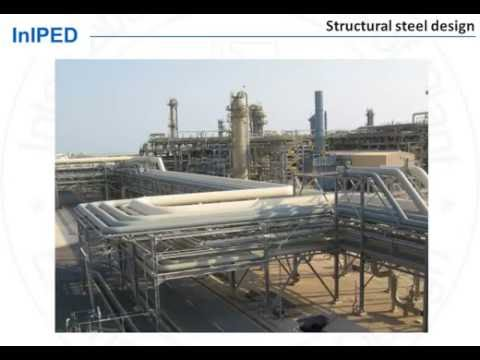

In [2]:
#@title Introduction to Oil & Gas facilities Design
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('ALfV6CNAQhU', width=600, height=400)

# Defining a well stream
Al simulations will start by defining a well stream as feed to the process plant. In the following example we set up a well stream using NeqSim.

In [0]:
#@title Defining a well stram
from neqsim.thermo import fluid, phaseenvelope
from neqsim.process import clearProcess, stream, valve, separator, compressor, runProcess, viewProcess, heater, mixer, recycle

feedPressure = 30.0


# Start by creating a fluid in neqsim
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 85.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 2.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.addComponent("n-hexane", 1.1)
fluid1.addComponent("n-heptane", 2.1)
fluid1.addComponent("n-octane", 1.1)
fluid1.addComponent("n-nonane", 0.51)
fluid1.addComponent("nC10", 5.1)
fluid1.setMixingRule('classic')
fluid1.setTemperature(35.15, "C")
fluid1.setPressure(feedPressure, "bara")
fluid1.setTotalFlowRate(5.0, "MSm3/day")

# Setting up a top side process
A top side process is defined starting with the well stream to an inlet separator. In the follwoing example we set up and simulate a standard top side process in NeqSim.

In [4]:
#@title Setting up a topside process simultion using NeqSim
from neqsim.thermo import fluid, phaseenvelope
from neqsim.process import clearProcess, stream, valve, separator, compressor, runProcess, viewProcess, heater, mixer, recycle

MPpressure = 10.0
LPpressure = 2.1

clearProcess()
stream1 = stream(fluid1)
separator1 = separator(stream1, "inlet separator")
valve1 = valve(separator1.getLiquidOutStream(), MPpressure, "HP oil valve")
separator2 = separator(valve1.getOutStream(), "MP separator")
valve2 = valve(separator2.getLiquidOutStream(), LPpressure)
separator3 = separator(valve2.getOutStream(), "LP separator")

compressorLP1 = compressor(separator3.getGasOutStream(), MPpressure)
coolerMP1 = heater(compressorLP1.getOutStream())
coolerMP1.setOutTemperature(303.0)
scrubberLP = separator(coolerMP1.getOutStream())

recycleLP = recycle(scrubberLP.getLiquidOutStream())
#separator2.addStream(recycleLP.getOutStream())

mixerLP = mixer()
mixerLP.addStream(scrubberLP.getGasOutStream())
mixerLP.addStream(separator2.getGasOutStream())

compressorMP1 = compressor(mixerLP.getOutStream(), feedPressure)
coolerMP1 = heater(compressorMP1.getOutStream())
coolerMP1.setOutTemperature(303.0)
scrubberMP1 = separator(coolerMP1.getOutStream())

recycleMP = recycle(scrubberMP1.getLiquidOutStream())
#separator1.addStream(recycleMP.getOutStream())

mixer1 = mixer()
mixer1.addStream(scrubberMP1.getGasOutStream())
mixer1.addStream(separator1.getGasOutStream())

compressor1 = compressor(mixer1.getOutStream(), 60.0)  # add compressor and set out pressure
compressor1.setIsentropicEfficiency(0.8)
cooler1 = heater(compressor1.getOutStream())
cooler1.setOutTemperature(303.0)
compressor2 = compressor(cooler1.getOutStream(), 120.0)
compressor2.setIsentropicEfficiency(0.77)

runProcess()

print("LPcompressor power ", compressorLP1.getPower()/1e6, " MW")
print("MPcompressor power ", compressorMP1.getPower()/1e6, " MW")
print("compressor1 power ", compressor1.getPower()/1e6, " MW")
print("compressor2 power ", compressor2.getPower()/1e6, " MW")

LPcompressor power  0.09590979188587616  MW
MPcompressor power  0.16551525593771121  MW
compressor1 power  4.908395066269919  MW
compressor2 power  4.743008563644452  MW


# Calculating the mechanical design
A mechanical design can be automaically calculated using the built in design rules in NeqSim. A design of a separato is given in the following example.

In [5]:
separator1.getMechanicalDesign().setMaxOperationPressure(150.0);
separator1.addSeparatorSection("tray", "");
separator1.getMechanicalDesign().calcDesign();
sepDesign = separator1.getMechanicalDesign()

print("Inlet seperator module length ", sepDesign.getModuleLength(), " m")
print("Inlet seperator module height ", sepDesign.getModuleHeight(), " m")
print("Inlet separartor module total weight ", sepDesign.getWeightTotal(), " kg")

Inlet seperator module length  16.36161738838289  m
Inlet seperator module height  5.363097970235437  m
Inlet separartor module total weight  21692.34857594136  kg


# Calculating a process with a recycle stream
The following example demonstrates the simulation of a process with a inlet separator, a gas cooler and a gas scrubber with resirculation of the liquids back to the inlet separator. It also shows how to modify inlet conditions and re-run the simulation.

In [6]:
from neqsim.thermo import fluid, createfluid, TPflash,printFrame,fluidcreator
from neqsim.process import mixer, separator3phase, clearProcess, stream, valve, separator, recycle, compressor, runProcess, viewProcess, heater

fluidcreator.setHasWater(True)
fluid1 = createfluid('gas condensate')
TPflash(fluid1)

#Setting inlet temperature and pressure
fluid1.setTemperature(45.0, 'C')
fluid1.setPressure(50.0, 'bara')


clearProcess()
stream_inlet = stream(fluid1)
mixer1 = mixer("mixer")
mixer1.addStream(stream_inlet)
separator_inlet = separator3phase(mixer1.getOutStream())
steam_gasFromSep = separator_inlet.getGasOutStream()
cooler_gasFromInletSep = heater(steam_gasFromSep)
cooler_gasFromInletSep.setOutTemperature(293.15)
stream_gasFromCooler = cooler_gasFromInletSep.getOutStream()
separator_scrubber = separator(stream_gasFromCooler)
recycle_liquid = recycle(separator_scrubber.getLiquidOutStream())
mixer1.addStream(recycle_liquid.getOutStream())

runProcess()
printFrame(separator_scrubber.getThermoSystem())

#Setting new inlet temperature
stream_inlet.getThermoSystem().setTemperature(40.0, "C")
runProcess()
printFrame(separator_scrubber.getThermoSystem())

                          total          gas          oil      aqueous                   
           nitrogen  3.09458E-2   3.09933E-2   3.32334E-3   3.29828E-9    [mole fraction]
                CO2  3.90405E-2    3.9099E-2   2.48681E-2   1.95005E-5    [mole fraction]
            methane  8.22122E-1   8.23372E-1   2.30913E-1   1.54025E-7    [mole fraction]
             ethane  7.20188E-2   7.21239E-2   8.63307E-2  2.83063E-10    [mole fraction]
            propane   2.1978E-2   2.20069E-2   7.46096E-2  3.83159E-14    [mole fraction]
           i-butane  4.14675E-3   4.15116E-3   2.93697E-2  1.01517E-17    [mole fraction]
           n-butane    3.842E-3   3.84545E-3   3.67787E-2  1.54985E-17    [mole fraction]
          i-pentane  1.66111E-3   1.66138E-3   3.40853E-2  2.05345E-20    [mole fraction]
          n-pentane  1.34917E-3   1.34889E-3   3.50267E-2  9.10849E-21    [mole fraction]
           n-hexane  5.62693E-4   5.60951E-4    3.8891E-2   2.2411E-24    [mole fraction]
          